In [13]:
import pandas as pd
import glob
import networkx as nx
from node2vec import Node2Vec
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 1. Analysefunktion für CSV-Dateien
def erste_analyse(name):
    df=pd.read_csv(name)

    head= df.head(3)
    shape=df.shape
    nan_sum =df.isna().sum()
    null_prozent = (df.isna().mean() * 100).round(2)
    dtype_info = df.dtypes
    
    print(f"\nAnalyse für Datei: {name}")
    print('-'*50)
    print(f'{head}\n')
    print("\nShape:", shape)
    print("\nFehlende Werte pro Spalte:\n", nan_sum)
    print("\nFehlende Werte in %:\n", null_prozent)
    print("\nDatentypen pro Spalte:\n", dtype_info)
    print('='*50)
    return {"head": head,
            "shape": shape,
            'nun_sum': nan_sum,
            'null_prozent': null_prozent, 
            'dtype_info': dtype_info
            }

In [ ]:
# 2. CSV-Dateien laden und analysieren
dateien = glob.glob("*.csv")  # Alle CSV-Dateien im aktuellen Ordner
for datei in dateien:
    erste_analyse(datei)  # Analyse jeder Datei


Analyse für Datei: PS_20174392719_1491204439457_log.csv
--------------------------------------------------
   step      type   amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT  9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT  1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER   181.00  C1305486145          181.0            0.00   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  


Shape: (6362620, 11)

Fehlende Werte pro Spalte:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Fehlende Wert

In [ ]:
# 3. Spezifische Datei einladen und Stichprobe erzeugen
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

'''# Erstelle einen gerichteten Graphen
G = nx.DiGraph()

# Füge Kanten (Transaktionen) zum Graphen hinzu
for index, row in df.iterrows():
    G.add_edge(row['nameOrig'], row['nameDest'], amount=row['amount'])'''

"# Erstelle einen gerichteten Graphen\nG = nx.DiGraph()\n\n# Füge Kanten (Transaktionen) zum Graphen hinzu\nfor index, row in df.iterrows():\n    G.add_edge(row['nameOrig'], row['nameDest'], amount=row['amount'])"

In [5]:
# Erstelle eine Stichprobe von Transaktionen
df_sample = df.sample(n=100000, random_state=42)  # Beispiel: 100.000 Transaktionen

In [6]:
# Erstelle den Graphen aus der Stichprobe
G_sample = nx.DiGraph()
edges_sample = [(row['nameOrig'], row['nameDest'], {'amount': row['amount']}) for index, row in df_sample.iterrows()]
G_sample.add_edges_from(edges_sample)

In [8]:
# Erstelle eine Kantenliste
edges = G_sample.edges(data=True)  # Gibt die Kanten mit Attributen zurück
edges_list = [(u, v, d['amount']) for u, v, d in edges]  # Extrahiere nur die Knoten und den Betrag
edges_df = pd.DataFrame(edges_list, columns=['source', 'target', 'amount'])

print(edges_df.head())  # Zeige die ersten paar Kanten

        source       target      amount
0   C632336343   C834976624   330218.42
1  C1264712553   M215391829    11647.08
2  C1746846248  C1607284477   152264.21
3   C333676753  C1564353608  1551760.63
4   C813403091  C1091768874    78172.30


In [ ]:
# 5. Node2Vec Feature-Engineering
# Erstelle das Node2Vec-Modell
node2vec = Node2Vec(G_sample, dimensions=64, walk_length=30, num_walks=200, workers=4)



Computing transition probabilities: 100%|██████████| 192912/192912 [00:03<00:00, 61098.89it/s]


In [10]:
# Trainiere das Modell
model = node2vec.fit()



In [11]:
# Extrahiere die Knotenvektoren
node_vectors = {node: model.wv[node] for node in model.wv.index_to_key}

In [ ]:
# Erstelle ein DataFrame aus den Knotenvektoren
df_vectors = pd.DataFrame.from_dict(node_vectors, orient='index')
df_vectors.columns = [f'Feature_{i}' for i in range(df_vectors.shape[1])]

# 6. Anomalieerkennung mit Isolation Forest
# Wende Isolation Forest an
clf = IsolationForest(contamination=0.01)  # Setze den Kontaminationswert basierend auf deinem Wissen über Anomalien
df_vectors['anomaly'] = clf.fit_predict(df_vectors)

# Ergebnisse analysieren
print(df_vectors[df_vectors['anomaly'] == -1])  # Zeigt die identifizierten Anomalien

             Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
C1085553281   0.384581  -0.690020   0.296370   1.296259  -0.588104  -1.142843   
C1009406898   0.414066  -0.461122  -0.448102   0.810000   0.178170  -0.091872   
C1040847151   0.653809  -0.291368   1.012079  -0.101666   0.571673  -1.006837   
C1849014975   0.826823  -1.487705  -0.518709   0.516126   1.080624  -0.683861   
C1495761010   0.347382  -1.225120  -1.016580  -0.084546   0.997644  -0.818649   
...                ...        ...        ...        ...        ...        ...   
C1533264160   0.504392  -0.954617   0.192087  -0.320158   0.810085  -0.614715   
C1790558058   0.219870  -0.958810   0.454479   0.206702  -0.105383  -0.802721   
C1561974083   0.405791  -0.646819  -1.005737   0.394802   1.291640  -0.179478   
C1204640379   0.262928  -0.457729  -0.146649  -0.230003   0.841391   0.181571   
C1369223685   0.029045  -0.885306  -0.032998   0.198515   0.979561  -0.434298   

             Feature_6  Fea

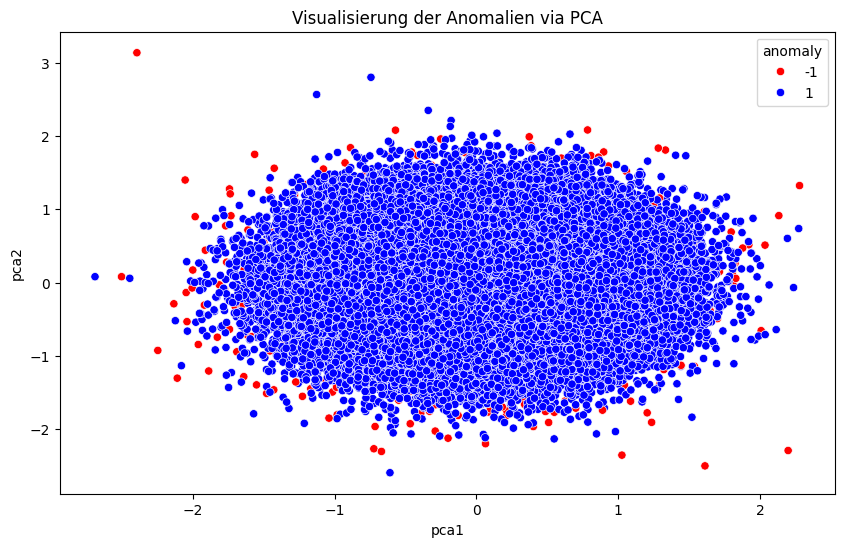

In [15]:
# 8. Visualisierung mit PCA oder TSNE (optional)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_vectors.drop('anomaly', axis=1))
df_vectors['pca1'] = pca_result[:, 0]
df_vectors['pca2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_vectors, x='pca1', y='pca2', hue='anomaly', palette={1: 'blue', -1: 'red'})
plt.title('Visualisierung der Anomalien via PCA')
plt.show()

In [16]:
# 9. Optional: Speichern für Graph-Datenbank
edges_out = pd.DataFrame(edges_sample, columns=['source', 'target', 'amount'])
edges_out.to_csv('graph_edges.csv', index=False)
df_vectors.reset_index().rename(columns={'index': 'node'}).to_csv('node_embeddings.csv', index=False)


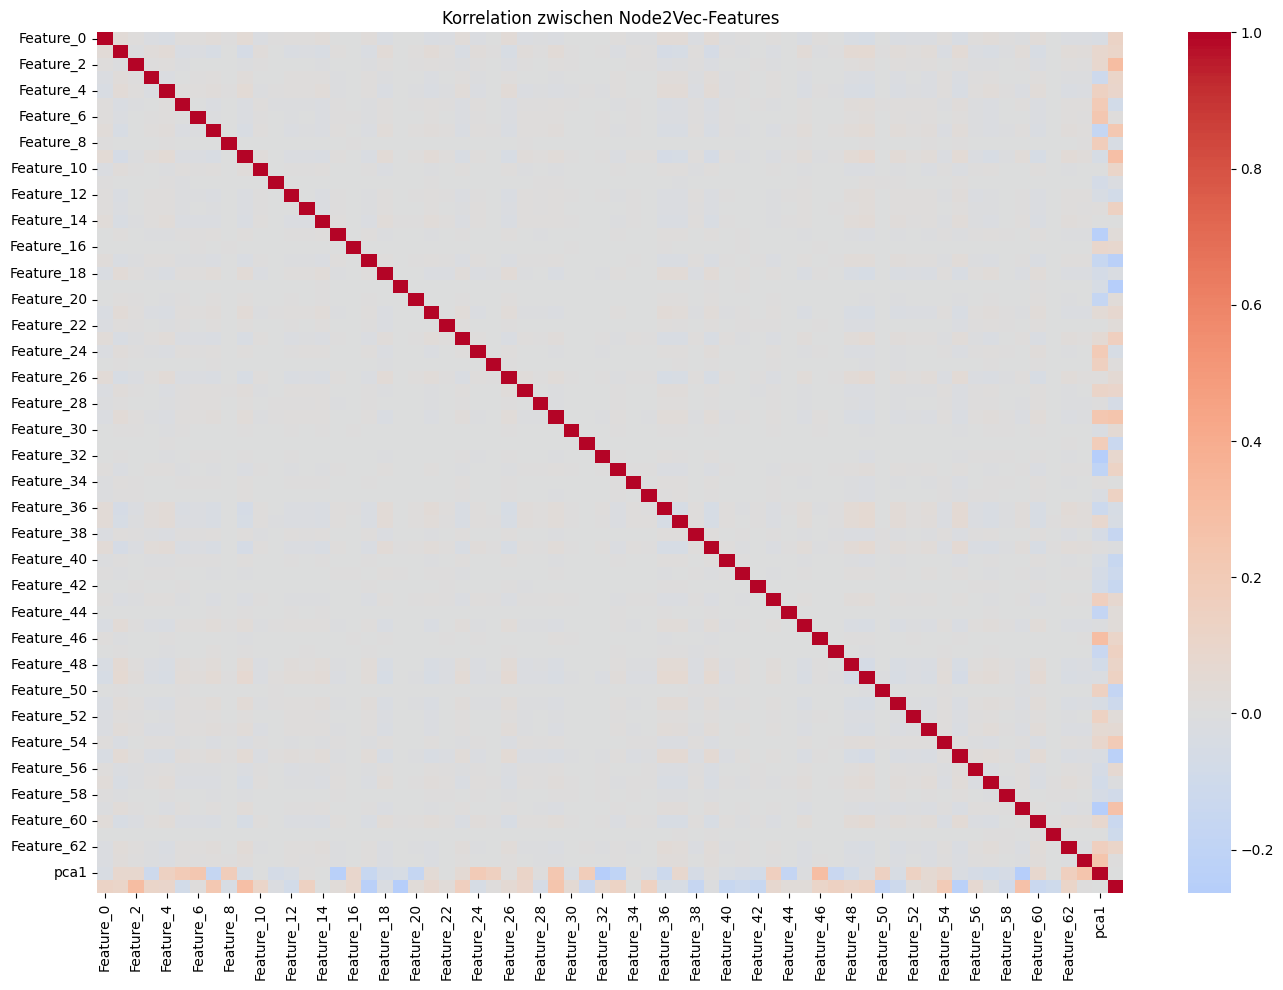

In [17]:


# Korrelationen berechnen (ohne 'anomaly', 'pca1', 'pca2', falls vorhanden)
corr_matrix = df_vectors.drop(columns=['anomaly'], errors='ignore').corr()

# Plotten
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f")
plt.title('Korrelation zwischen Node2Vec-Features')
plt.tight_layout()
plt.show()


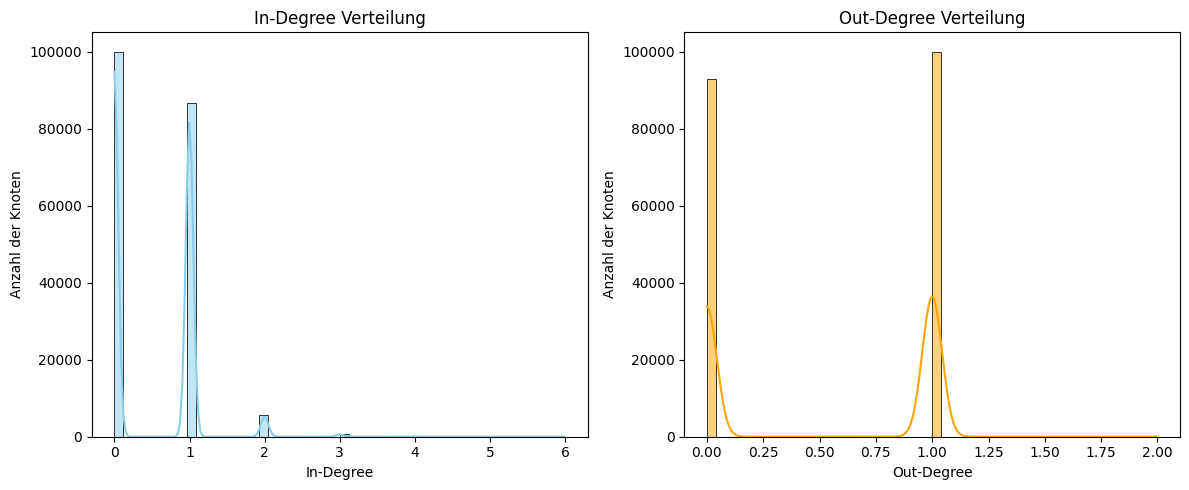

In [18]:
# Für gerichteten Graph: In-Degree & Out-Degree getrennt betrachten
in_degrees = [deg for node, deg in G_sample.in_degree()]
out_degrees = [deg for node, deg in G_sample.out_degree()]

# Plotten
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(in_degrees, bins=50, kde=True, color='skyblue')
plt.title('In-Degree Verteilung')
plt.xlabel('In-Degree')
plt.ylabel('Anzahl der Knoten')

plt.subplot(1, 2, 2)
sns.histplot(out_degrees, bins=50, kde=True, color='orange')
plt.title('Out-Degree Verteilung')
plt.xlabel('Out-Degree')
plt.ylabel('Anzahl der Knoten')

plt.tight_layout()
plt.show()


Interpretation:
Einzelne Peaks → viele Nodes mit gleich vielen Verbindungen (z. B. Systemfehler?)

Lange Tails (Skalierung) → Hinweis auf Power-Law → typische Netzwerkeigenschaft

Outlier mit sehr hohem Degree → Anomaliekandidaten!

 **Top-N Anomalien nach Häufigkeit (Kundenanalyse):**

In [19]:
# Filtere Anomalien
anomaly_nodes = df_vectors[df_vectors['anomaly'] == -1].index

# Zähle wie oft ein Kunde in Transaktionen vorkommt
anomalie_counts = df_sample[df_sample['nameOrig'].isin(anomaly_nodes) | df_sample['nameDest'].isin(anomaly_nodes)]
top_kunden = pd.concat([anomalie_counts['nameOrig'], anomalie_counts['nameDest']]).value_counts().head(10)

print("Top-10 verdächtige Kunden:")
print(top_kunden)


Top-10 verdächtige Kunden:
C1085553281    6
C1269097316    5
C1674899618    5
C709091500     5
C1657041838    5
C1495761010    5
C681078805     5
C1849014975    5
C1009406898    5
C1040847151    5
dtype: int64


**Transaktionsbeträge: Anomalien vs. Normal:**

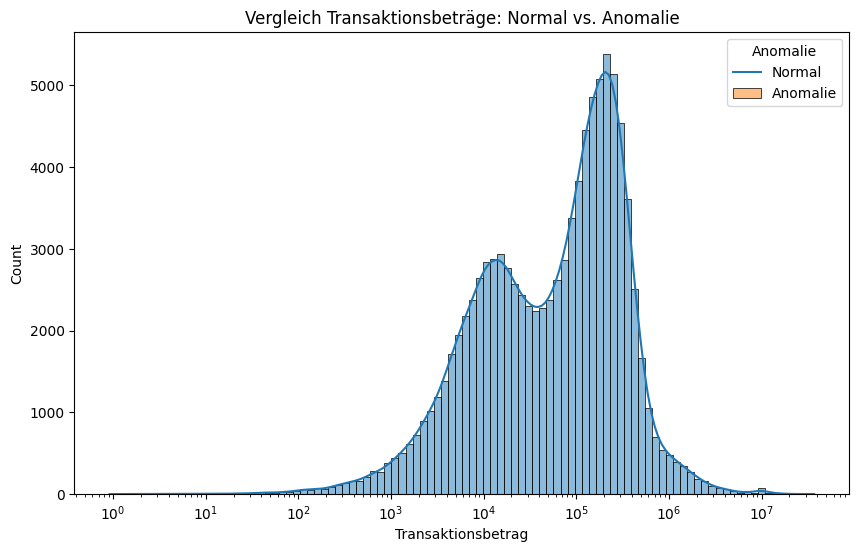

In [20]:
# Anomalie-Knoten
anomalie_knoten = df_vectors[df_vectors['anomaly'] == -1].index

# Label zu Original-DataFrame mergen
df_sample['anomaly'] = df_sample['nameOrig'].isin(anomalie_knoten).astype(int)

# Plotten
plt.figure(figsize=(10,6))
sns.histplot(data=df_sample, x='amount', hue='anomaly', bins=100, log_scale=True, kde=True)
plt.title('Vergleich Transaktionsbeträge: Normal vs. Anomalie')
plt.xlabel('Transaktionsbetrag')
plt.legend(title='Anomalie', labels=['Normal', 'Anomalie'])
plt.show()


**Feature Importance (RandomForest statt IsolationForest)**:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = df_vectors.drop(columns='anomaly')
y = df_vectors['anomaly']

rf = RandomForestClassifier()
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 wichtige Features laut Random Forest")
plt.show()


**Hybrid-Modell: Node2Vec + Original Features**:

In [ ]:
# 1. Extrahiere relevante Features aus df_sample
user_features = df_sample.groupby('nameOrig')['amount'].agg(['mean', 'sum', 'count'])
user_features.columns = ['avg_amount', 'total_amount', 'num_tx']

# 2. Kombiniere mit Node2Vec-Vektoren
df_combined = df_vectors.join(user_features, how='left')
df_combined = df_combined.fillna(0)

# Jetzt kannst du darauf ML machen:
# z. B. erneut IsolationForest oder klassisch RandomForest
